In [34]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use('fivethirtyeight') 

# Increasing Temperatures and Related Health Impacts
**Student:** Emily Nilson


## Introduction
Our planet is getting warmer. This summer has [set records](https://www.washingtonpost.com/news/capital-weather-gang/wp/2018/07/03/hot-planet-all-time-heat-records-have-been-set-all-over-the-world-in-last-week/?utm_term=.117468c8c1a6) in the Northern Hemisphere, from [Europe to Japan to North America](https://www.cnn.com/2018/07/23/world/global-heatwaves-climate-change-wxc/index.html),  and it is going to be one of the [hottest summers on record](https://www.cnn.com/2018/07/28/us/2018-global-heat-record-4th-wxc/index.html). Increasing temperatures and more frequent and longer heat waves have clear impacts on human health. It is important to understand how temperatures are expected to change and how many people could potentially be vulnerable
so adequate measures can be taken to mitigate risks: raise awareness of the dangers of high temperatures, ensure electric grid reliability to power air conditioners, ensure ample capacity for hospitals and medical facilities to treat patients, etc.

## Project Overview
This project will explore the relationships between heat-related hospitalizations in the United States and a number of heat-related climate variables, including:
- Average High Temperature
- Extreme Heat Events
- Heat Wave Incidents

## Data Sets and Sources
### Heat-Related Hospitalizations
Number of hospitalizations for heat stress per year by state
- Center for Disease Control and Prevention's [National Environmental Public Health Tracking Network](https://ephtracking.cdc.gov/DataExplorer/#/)
- Data are based on the date of admission, which is limited to between May 1 and September 30 for each year. Data represent number of admissions rather than number of individuals (individual can be admitted more than once). Blanks or missing data were either not collected, not provided to the CDC, or were incomplete or did not meet data quality standards.
- Citation: Centers for Disease Control and Prevention. Environmental Public Health Tracking Network. State Hospital Inpatient Discharge data. Accessed From Environmental Public Health Tracking Network: www.cdc.gov/ephtracking. Accessed on 08/18/2018

### Climate Indicators
- [LOCA Statistical Downscaling (Localized Constructed Analogs)](http://loca.ucsd.edu/)
- The compressed LOCA dataset is over 10 terabytes -- it's massive. It contains only three elements: daily maximum temperature, daily minimum temperature, and precipitation. The data is quite unweildy and complex to work with (NetCDF format), so there are several initiatives to make it more accessible for climate adaptation and resilience planning. 
    - One is [PREPdata](https://www.prepdata.org/) from the Partnership for Resilience and Preparedness (for which I manage the platform). We provide decadal and 30-year summaries for several climate indicators derived from the processed data. 
    - Another source is the [Azavea Climate API](https://climate.azavea.com/), which provides point-by-point data for 22 climate indicators for 1000+ locations across the U.S. The data is available through queries to the API (though there are rather low rate limits, as I've found)
    
**Using the Climate API**

The API accepts GET, POST, PUT, PATCH, and DELETE HTTP requests. For GET requests that accept parameters, required parameters are specified in the path. Optional parameters are accepted as an HTTP query string parameter:

`https://app.climate.azavea.com/api/climate-data/1/RCP45/indicator/average_high_temperature/?years=2050&units=C`

In the above, the `city` is represented by `1`, the `climate scenario` is `RCP 4.5`, and the `indicator` is `Average High Temperature`. The querystring also contains additional elements, including `years` as `2005` and `units` as `degrees Celsius`. 


**Selected climate indicators**
- **Average High Temperature**: Average High Temperature is calculated by aggregating daily average high temperatures. It is an appropriate metric for probable long term temperature trends.
- **Extreme Heat Events**: Extreme Heat Events counts the total times the daily average maximum temperature is above some percentile of historic observations. The percentile defaults to 99, referring to the hottest percentile of historic daily temperatures. It is an appropriate indicator for understanding deviations from normal climatic extremes. 
- **Heat Wave Incidents**: Heat Wave Incidents counts the days the daily high temperature exceeds 5˚C above historic average high temperature norms for at least 5 consecutive days. This indicator is closely paired with heat wave duration index and, similarly, provides a concrete and palpable metric to the impacts of global warming. Frequency, duration, and intensity predictions of heat waves are very important for health and emergency services planning.

## Goal for Model
Develop a basic model to predict heat-related hospitalizations based on climate indicators.

### Assumptions and known issues
- Hospitalizations are by state and I'm using only one point within the state to summarize the climate indicators
    - Ideally would want to take state polygon and summarize data, but Azavea's Climate API only allows point extraction
- Hospitalization data isn't as complete as I'd hoped -- it's only available for about half of the states

# NOTE:
Please see additional notebook (sent via email) for data collection and cleaning

In [2]:
path = Path('.', 'consolidated_indicators.csv')
final_df = pd.read_csv(path)

In [3]:
final_df.drop(columns={'Unnamed: 0'}, inplace=True)

In [4]:
final_df.head(20)

,state,city,year,hospitalizations,azavea_id,latitude,longitude,population,tasmax_median,xhe_median,hwi_median
0,Arizona,Phoenix,2006,336.0,9,33.448,-112.097,1445632,87.646080,5.0,3.0
1,Arizona,Phoenix,2007,312.0,9,33.448,-112.097,1445632,87.780368,7.0,2.0
2,Arizona,Phoenix,2008,297.0,9,33.448,-112.097,1445632,87.860642,8.0,2.0
3,Arizona,Phoenix,2009,378.0,9,33.448,-112.097,1445632,87.633112,10.0,2.0
4,Arizona,Phoenix,2010,453.0,9,33.448,-112.097,1445632,87.822657,7.0,3.0
5,California,Sacramento,2006,1100.0,41,38.577,-121.494,466488,75.991388,8.5,3.0
6,California,Sacramento,2007,571.0,41,38.577,-121.494,466488,76.020224,6.0,3.0
7,California,Sacramento,2008,571.0,41,38.577,-121.494,466488,75.652062,7.0,3.0
8,California,Sacramento,2009,516.0,41,38.577,-121.494,466488,75.707044,5.5,3.0
9,California,Sacramento,2010,503.0,41,38.577,-121.494,466488,75.655707,7.0,3.0


# Exploratory Data Analysis

In [5]:
final_df.shape

(115, 11)

In [6]:
final_df.columns

Index(['state', 'city', 'year', 'hospitalizations', 'azavea_id', 'latitude',
       'longitude', 'population', 'tasmax_median', 'xhe_median', 'hwi_median'],
      dtype='object')

### Data Types

In [7]:
final_df.dtypes

state                object
city                 object
year                  int64
hospitalizations    float64
azavea_id             int64
latitude            float64
longitude           float64
population            int64
tasmax_median       float64
xhe_median          float64
hwi_median          float64
dtype: object

### Handling Null Values

In [8]:
final_df.isnull().sum()

state               0
city                0
year                0
hospitalizations    0
azavea_id           0
latitude            0
longitude           0
population          0
tasmax_median       0
xhe_median          0
hwi_median          0
dtype: int64

### Basic Summary Statistics

In [9]:
final_df.describe()

,year,hospitalizations,azavea_id,latitude,longitude,population,tasmax_median,xhe_median,hwi_median
count,115.000000,115.000000,115.000000,115.000000,115.000000,1.150000e+02,115.000000,115.000000,115.000000
mean,2008.000000,151.565217,659.782609,39.942522,-91.202522,2.743603e+05,66.137135,6.147826,2.813043
std,1.420403,188.084347,683.172036,4.477801,17.467676,3.191201e+05,8.208394,1.458451,1.060579
min,2006.000000,1.000000,9.000000,30.438000,-123.030000,7.592000e+03,55.004270,3.000000,1.000000
25%,2007.000000,26.500000,49.000000,36.166000,-105.940000,5.030200e+04,59.616549,5.000000,2.000000
50%,2008.000000,80.000000,138.000000,40.777000,-86.784000,1.899070e+05,64.914607,6.000000,3.000000
75%,2009.000000,198.500000,1356.000000,43.207000,-74.770000,4.038920e+05,71.488606,7.000000,3.500000
max,2010.000000,1100.000000,1721.000000,47.036000,-69.782000,1.445632e+06,87.860642,10.500000,6.000000


### Exploring the Distribution of Independent Variables (Climate Indicators)
- `tasmax` = Average High Temperature (Aggregated daily average high temperatures
- `xhe` = Extreme Heat Events (Total times the daily average maximum temperature is above the 99th percentile of historic observations)
- `hwi` = Heat Wave Incidents (Days the daily high temperature exceeds 5˚C above historic average high temperature norms for at least 5 consecutive days)

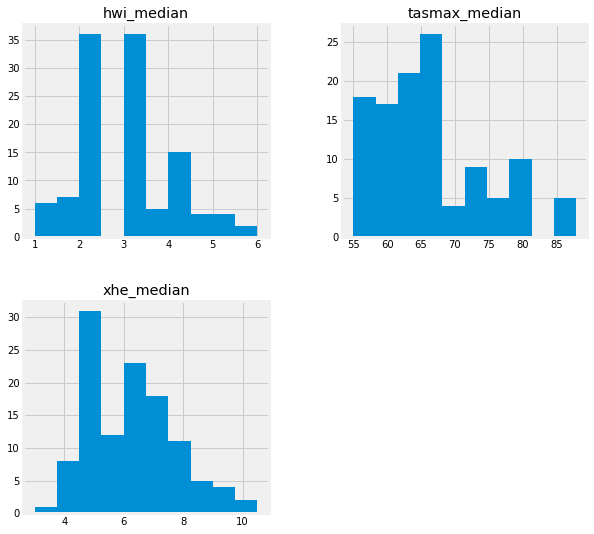

In [10]:
axes = final_df.hist(column=['tasmax_median', 'xhe_median', 'hwi_median'], figsize=(9,9))

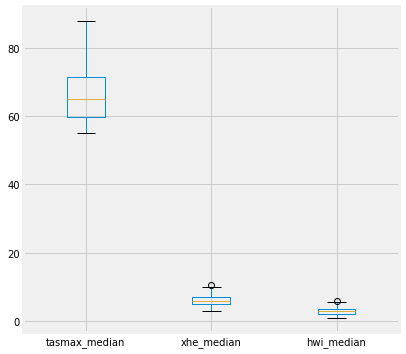

In [11]:
columns = ['tasmax_median', 'xhe_median', 'hwi_median']

ax = final_df.loc[:, columns].plot(kind='box', figsize=(6,6))

### Exploring the Distribution of Dependent Variable (# Hospitalizations)

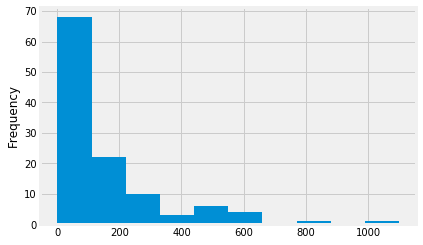

In [12]:
ax = final_df.loc[:, 'hospitalizations'].plot(kind='hist')

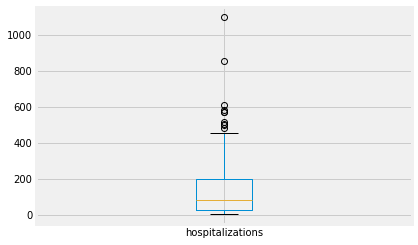

In [13]:
ax = final_df.loc[:, 'hospitalizations'].plot(kind='box')

Hospitalizations are very skewed.

## Adding **Rate** of Hospitalizations

Rate = Hospitalizations / Population 

In [14]:
final_df.loc[:, 'hosp_rate'] = (final_df.loc[:, 'hospitalizations'] / final_df.loc[:, 'population'])

In [15]:
final_df.head()

,state,city,year,hospitalizations,azavea_id,latitude,longitude,population,tasmax_median,xhe_median,hwi_median,hosp_rate
0,Arizona,Phoenix,2006,336.0,9,33.448,-112.097,1445632,87.646080,5.0,3.0,0.000232
1,Arizona,Phoenix,2007,312.0,9,33.448,-112.097,1445632,87.780368,7.0,2.0,0.000216
2,Arizona,Phoenix,2008,297.0,9,33.448,-112.097,1445632,87.860642,8.0,2.0,0.000205
3,Arizona,Phoenix,2009,378.0,9,33.448,-112.097,1445632,87.633112,10.0,2.0,0.000261
4,Arizona,Phoenix,2010,453.0,9,33.448,-112.097,1445632,87.822657,7.0,3.0,0.000313


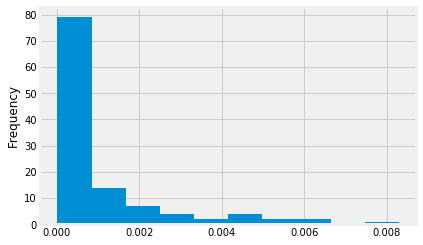

In [16]:
ax = final_df.loc[:, 'hosp_rate'].plot(kind='hist')

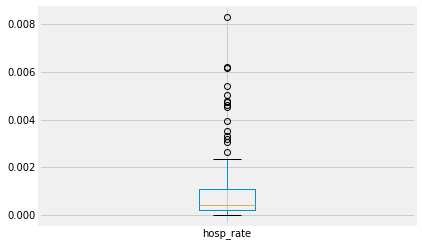

In [17]:
ax = final_df.loc[:, 'hosp_rate'].plot(kind='box')

Hospitalization *Rate* is similarly skewed.

## Exploring Relationships for Whole Dataset

### Overall heatmap

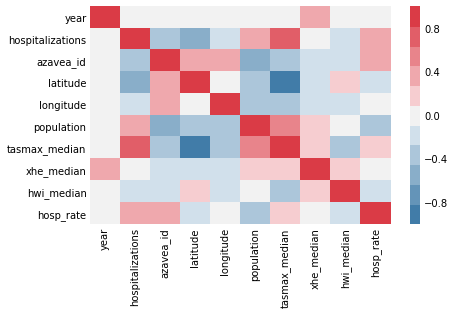

In [18]:
ax = sns.heatmap(final_df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 10, n=11))

The only notable correlation visible on the heatmap is Average High Temperature (`tasmax`) compared to Hospitalizations.

### Plotting climate indicators against # of hospitalizations

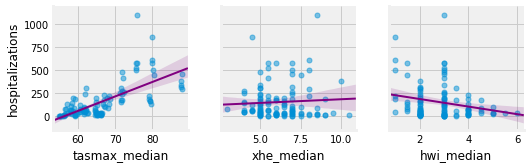

In [19]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

g = sns.pairplot(final_df,
                x_vars = feature_cols, 
                y_vars = 'hospitalizations',
                kind = 'reg',
                plot_kws = {'scatter_kws': {'alpha': 0.5, 's':25}, 
                            'line_kws': {'color': 'purple', 'lw':2}})

#### There appears to be some relationship between Average High Temperature (`tasmax`) and Number of Hospitalizations


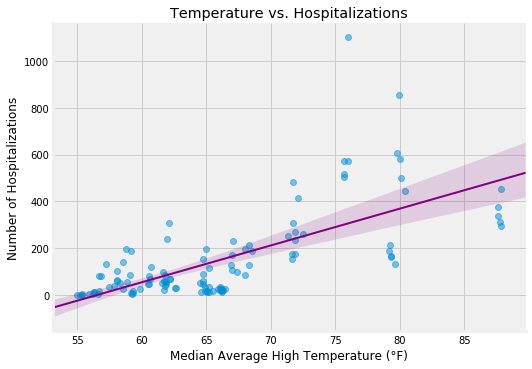

In [20]:
g = sns.lmplot(x='tasmax_median', 
           y='hospitalizations',
           data=final_df,
           aspect=1.5,
           scatter_kws={'alpha': 0.5},
           line_kws={'lw':2, 'color': 'purple'}
           )
g.set_axis_labels('Median Average High Temperature (°F)', 'Number of Hospitalizations');
g.ax.set_title('Temperature vs. Hospitalizations');

There indeed appears to be a linear relationship, so a Linear Regression model using at least this variable will be good to test.

### Plotting climate indicators against hospitalization rate

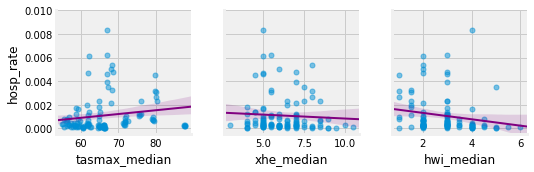

In [21]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

g = sns.pairplot(final_df,
                x_vars = feature_cols, 
                y_vars = 'hosp_rate',
                kind = 'reg',
                plot_kws = {'scatter_kws': {'alpha': 0.5, 's':25}, 
                            'line_kws': {'color': 'purple', 'lw':2}})

g.set(ylim=(-0.0005,0.01));

#### Comparing the best fit regression line above to one for Average High Temperature (`tasmax`) and Hospitalization Rate

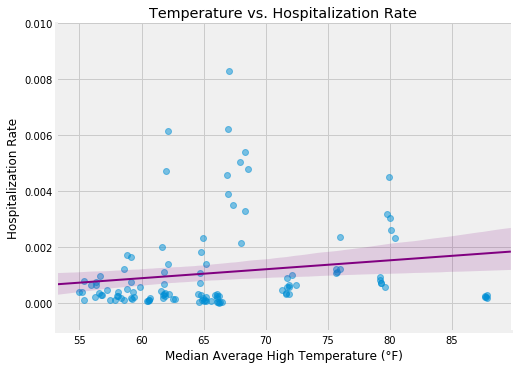

In [22]:
g = sns.lmplot(x='tasmax_median', 
           y='hosp_rate',
           data=final_df,
           aspect=1.5,
           scatter_kws={'alpha': 0.5},
           line_kws={'lw':2, 'color': 'purple'}
           )
g.set(ylim=(-0.001,0.01))
g.set_axis_labels('Median Average High Temperature (°F)', 'Hospitalization Rate')
g.ax.set_title('Temperature vs. Hospitalization Rate');

Median Average High Temperature and Hospitalizations (#) seems to have a better linear fit than hospitalization *rate*.

## Exploring Relationships for a Single Year (2006)

To compare how it looks compared to the entire dataset

In [23]:
final_df_2006 = final_df.loc[(final_df.loc[:, 'year'] == 2006), :]
final_df_2006.head()

,state,city,year,hospitalizations,azavea_id,latitude,longitude,population,tasmax_median,xhe_median,hwi_median,hosp_rate
0,Arizona,Phoenix,2006,336.0,9,33.448,-112.097,1445632,87.646080,5.0,3.0,0.000232
5,California,Sacramento,2006,1100.0,41,38.577,-121.494,466488,75.991388,8.5,3.0,0.002358
10,Colorado,Denver,2006,29.0,30,39.739,-104.985,682545,66.180085,7.0,4.0,0.000042
15,Connecticut,Hartford,2006,54.0,1653,41.764,-72.682,124006,61.590789,4.5,2.0,0.000435
20,Florida,Tallahassee,2006,500.0,138,30.438,-84.281,189907,80.077949,8.0,1.0,0.002633


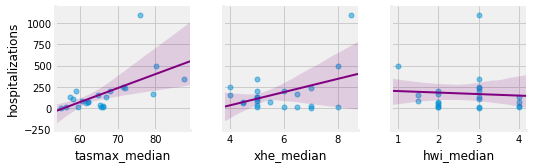

In [24]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

g = sns.pairplot(final_df_2006,
                x_vars = feature_cols, 
                y_vars = 'hospitalizations',
                kind = 'reg',
                plot_kws = {'scatter_kws': {'alpha': 0.5, 's':25}, 
                            'line_kws': {'color': 'purple', 'lw':2}})

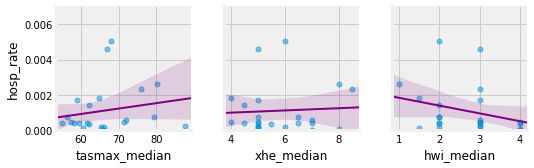

In [25]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

g = sns.pairplot(final_df_2006,
                x_vars = feature_cols, 
                y_vars = 'hosp_rate',
                kind = 'reg',
                plot_kws = {'scatter_kws': {'alpha': 0.5, 's':25}, 
                            'line_kws': {'color': 'purple', 'lw':2}})

g.set(ylim=(0,0.007));

Can see similar patterns to the whole dataset.

## Checking for Collinearity Between Variables

Average High Temperature versus Extreme Heat Events

/Users/emilynilson/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


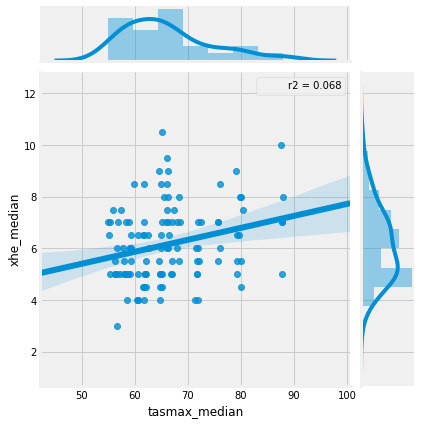

In [26]:
x = final_df.loc[:, 'tasmax_median']
y = final_df.loc[:, 'xhe_median']

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(x, y, kind="reg", stat_func=r2);

Average High Temperature versus Heat Wave Incidents

/Users/emilynilson/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


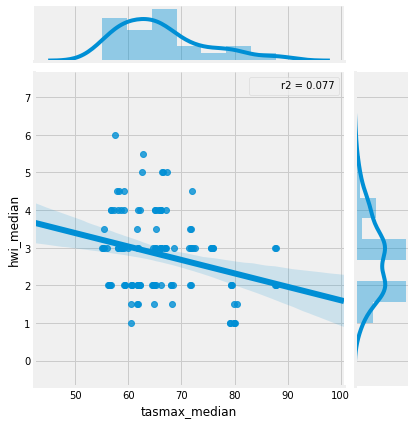

In [27]:
x = final_df.loc[:, 'tasmax_median']
y = final_df.loc[:, 'hwi_median']

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(x, y, kind="reg", stat_func=r2);

Heat Wave Incidents versus Extreme Heat Events

/Users/emilynilson/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


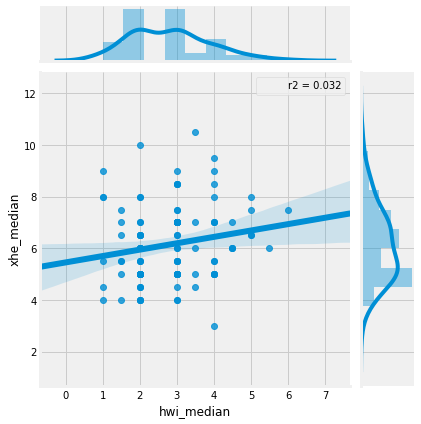

In [28]:
x = final_df.loc[:, 'hwi_median']
y = final_df.loc[:, 'xhe_median']

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(x, y, kind="reg", stat_func=r2);

### Evaluating Collinearity

Since the $r^2$ value is < 0.7 in each of these instances, we can safely assume the variables are not correlated with one another.

# Time to build a model!

# Linear Regression

## Step 1: Establish a Baseline
### Test a linear regression model on the dataset *as is*, with all years. 

For this initial simplified model:
- Use all three climate variables, for both number of hospitalizations and hospitalization rate
- For each, do a simple train-test-split and evaluate with k-fold cross validation

### All Three Climate Indicators + *Number* of Hospitalizations for Whole Dataset [Initial Baseline Model]
#### Simple Train-Test-Split

In [133]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) 

lr_three_hosp = LinearRegression()
lr_three_hosp.fit(X_train, y_train)

y_pred = lr_three_hosp.predict(X_test)

# MSE/RMSE on training set
print('Training Scores')
print('MSE Training:', metrics.mean_squared_error(y_train, lr_three_hosp.predict(X_train)))
print('RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, lr_three_hosp.predict(X_train))))

# MSE/RMSE on test set
print('Testing Scores')
print('MSE Testing:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared Testing:', lr_three_hosp.score(X_test, y_test))

Training Scores
MSE Training: 11571.23572624471
RMSE Training: 107.56967847049052
Testing Scores
MSE Testing: 38958.81658568011
RMSE Testing: 197.3798788774583
R-Squared Testing: 0.3521253755025406


When looking at these initial results, the testing errors are notably higher than the training errors, suggesting the model has a variance problem and is overfitting.

### All Three Climate Indicators + Number of Hospitalizations for Whole Dataset [Initial Baseline Model]
#### K-Fold Cross Validation
With $k=10$

In [134]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']
X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

kf = model_selection.KFold(n_splits=10, shuffle=True)

mse_training_values = []
rmse_training_values = []
mse_testing_values = []
rmse_testing_values = []

for train_indices, test_indices in kf.split(X, y):
    lr = LinearRegression() 
    X_train = X.iloc[train_indices, :] 
    y_train = y.iloc[train_indices]
    lr.fit(X_train, y_train) 
    
    X_test = X.iloc[test_indices, :]
    y_test = y.iloc[test_indices]
    
    y_pred = lr.predict(X_test)
    
    mse_train = metrics.mean_squared_error(y_train, lr.predict(X_train))
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train)))
    mse_training_values.append(mse_train)
    rmse_training_values.append(rmse_train)
    
    mse_test = metrics.mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mse_testing_values.append(mse_test)
    rmse_testing_values.append(rmse_test)

print('MSE Training:', mse_training_values)
print('RMSE Training:', rmse_training_values)
print('MSE Testing:', mse_testing_values)
print('RMSE Testing:', rmse_testing_values)

MSE Training: [11551.607470244684, 17727.211538742944, 17423.884045390027, 18057.99395010049, 19178.96306540517, 19300.26627183328, 18398.570891094794, 19608.265204476957, 19215.289527529818, 19185.980116413455]
RMSE Training: [107.47840466923894, 133.14357490597487, 131.9995607772618, 134.38003553393074, 138.48813330175682, 138.92539822449055, 135.64133179490238, 140.02951547612008, 138.61922495646056, 138.51346546965553]
MSE Testing: [75862.2162278382, 22493.539419460332, 25483.0671479681, 18181.435601948448, 9057.522713201495, 6842.184680404508, 16731.603591923045, 3467.9783966958817, 7332.9487995539685, 7633.431517656232]
RMSE Testing: [275.4309645407324, 149.97846318541983, 159.63416660592463, 134.83855384106005, 95.17101824190753, 82.71749923930551, 129.35070000553938, 58.88954403538782, 85.63263863477505, 87.36951137356917]


#### Average MSE/RMSE from the K-Fold Cross Validation

In [135]:
print('Avg Train MSE:', sum(mse_training_values)/float(len(mse_training_values)))
print('Avg Train RMSE:', sum(rmse_training_values)/float(len(rmse_training_values)))
print('Avg Test MSE:', sum(mse_testing_values)/float(len(mse_testing_values)))
print('Avg Test RMSE:', sum(rmse_testing_values)/float(len(rmse_testing_values)))

Avg Train MSE: 17964.803208123165
Avg Train RMSE: 133.7218645109792
Avg Test MSE: 19308.592809665024
Avg Test RMSE: 125.90130597036213


*Ensuring the cross_val_score method produces similar results for the test RMSE, which it does*

In [136]:
scores = cross_val_score(lr, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

125.19577980975355

On one run, the MSE training values ranged from 10,616 to 19,816, while the MSE testing values ranged from 11,455 to 50,546. There is a notable difference in their ranges, suggesting high variance (and overfitting of the model).

### All Three Climate Indicators + Number of Hospitalizations for Whole Dataset [Initial Baseline Model]
#### Looking at the coefficients

In [57]:
list(zip(X.columns, lr_three_hosp.coef_))

[('tasmax_median', 15.36496677797666),
 ('xhe_median', -25.035458250038747),
 ('hwi_median', -1.648143892557055)]

Seems odd. Model's prediction goes up with Average High Temperature, but down with Extreme Heat Events.

## Step 1, Continued: Establish a Baseline

### All Three Climate Indicators + Hospitalization *Rate* for Whole Dataset [Initial Baseline Model]
#### Simple Train-Test-Split

In [62]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hosp_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) 

lr_three_hosp_rate = LinearRegression()
lr_three_hosp_rate.fit(X_train, y_train)

y_pred = lr_three_hosp_rate.predict(X_test)

# MSE/RMSE on training set
print('Training Scores')
print('MSE Training:', metrics.mean_squared_error(y_train, lr_three_hosp_rate.predict(X_train)))
print('RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, lr_three_hosp_rate.predict(X_train))))

# MSE/RMSE on test set
print('Testing Scores')
print('MSE Testing:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared Testing:', lr_three_hosp_rate.score(X_test, y_test))

Training Scores
MSE Training: 2.5179291280944224e-06
RMSE Training: 0.0015867983892399256
Testing Scores
MSE Testing: 1.621858858463727e-06
RMSE Testing: 0.0012735222253513
R-Squared Testing: -0.034406279792635885


### All Three Climate Indicators + Hospitalization *Rate* for Whole Dataset [Initial Baseline Model]
#### K-Fold Cross Validation
With $k=10$

In [108]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']
X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hosp_rate']

kf = model_selection.KFold(n_splits=10, shuffle=True)

mse_training_values = []
rmse_training_values = []
mse_testing_values = []
rmse_testing_values = []

for train_indices, test_indices in kf.split(X, y):
    lr = LinearRegression() 
    X_train = X.iloc[train_indices, :] 
    y_train = y.iloc[train_indices]
    lr.fit(X_train, y_train) 
    
    X_test = X.iloc[test_indices, :]
    y_test = y.iloc[test_indices]
    
    y_pred = lr.predict(X_test)
    
    mse_train = metrics.mean_squared_error(y_train, lr.predict(X_train))
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train)))
    mse_training_values.append(mse_train)
    rmse_training_values.append(rmse_train)
    
    mse_test = metrics.mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mse_testing_values.append(mse_test)
    rmse_testing_values.append(rmse_test)

print('MSE Training:', mse_training_values)
print('RMSE Training:', rmse_training_values)
print('MSE Testing:', mse_testing_values)
print('RMSE Testing:', rmse_testing_values)

MSE Training: [2.3394462264278158e-06, 2.498892550108392e-06, 2.4551014135322725e-06, 2.141518230317202e-06, 2.3541647436023873e-06, 2.4038728205019204e-06, 2.3318747312361956e-06, 1.6674256814923944e-06, 2.234538483261535e-06, 2.291968116251253e-06]
RMSE Training: [0.0015295248368129939, 0.0015807885848867938, 0.0015668763236236203, 0.0014633927122673538, 0.0015343287599476154, 0.001550442782079339, 0.0015270477174064323, 0.001291288380452792, 0.0014948372765159206, 0.001513924739295601]
MSE Testing: [1.799084300413467e-06, 4.392889374868008e-07, 9.106729917925961e-07, 3.504574695830238e-06, 1.65305062105802e-06, 1.206875250341789e-06, 1.8538663803653875e-06, 8.410968555031392e-06, 2.763789960863962e-06, 2.2089076924218267e-06]
RMSE Testing: [0.0013412994819999994, 0.0006627887578156413, 0.0009542918797687614, 0.0018720509330224532, 0.0012857101621508715, 0.001098578741074935, 0.001361567618726807, 0.0029001669874390667, 0.0016624650254558626, 0.0014862394465300088]


#### Average MSE/RMSE from the K-Fold Cross Validation

In [109]:
print('Avg Train MSE:', sum(mse_training_values)/float(len(mse_training_values)))
print('Avg Train RMSE:', sum(rmse_training_values)/float(len(rmse_training_values)))
print('Avg Test MSE:', sum(mse_testing_values)/float(len(mse_testing_values)))
print('Avg Test RMSE:', sum(rmse_testing_values)/float(len(rmse_testing_values)))

Avg Train MSE: 2.2718802996731367e-06
Avg Train RMSE: 0.0015052452113288462
Avg Test MSE: 2.475107938560548e-06
Avg Test RMSE: 0.0014625159033984409


*Ensuring the cross_val_score method produces similar results for the test RMSE, which it does*

In [110]:
scores = cross_val_score(lr, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.0014380010252377316

### All Three Climate Indicators + Hospitalization *Rate* for Whole Dataset [Initial Baseline Model]
#### Looking at the coefficients

In [111]:
list(zip(X.columns, lr_three_hosp_rate.coef_))

[('tasmax_median', 3.967581537023609e-05),
 ('xhe_median', -0.00013841925613242774),
 ('hwi_median', -0.00013536674305768677)]

# Linear Regression, Continued

## Step 2: Separate the Training and Testing Data
### Train the Model on 2006-2009 Data and Test it on 2010 Data


The ultimate goal of this model is to be able to train it on historical data and test it on future, projected climate scenarios. In order to do this, the model needs to be trained on data from one time period and tested on another. Since I have data from 2006-2010, I will manually separate the data into training (2006-2009) and testing (2010) sets.

There are still several versions I want to test and compare, which I will do in the following order:
- **Number of Hospitalizations**
    - Null model (predicting `average` number of hospitalizations across dataset)
    - 3 climate indicators (`tasmax`, `xhe`, `hwi`)
    - 2 climate indicators (`tasmax`, `xhe`)
    - 1 climate indicator (`tasmax`)
- **Hospitalization Rate**
    - Null model (predicting `average` hospitalization rate across dataset)
    - 3 climate indicators (`tasmax`, `xhe`, `hwi`)
    - 2 climate indicators (`tasmax`, `xhe`)
    - 1 climate indicator (`tasmax`)
    
One caveat to this is that due to the way I'm manually separating the dataset by rows, I cannot do a k-fold cross validation. But I will evaluate model performance based on $MSE$, $RMSE$, and $R^2$

### Separating the Data

#### Training Set: 2006-2009

In [114]:
years_2006_2009 = final_df.loc[:, 'year'] < 2010
print(final_df.loc[years_2006_2009, :].shape)
final_df.loc[years_2006_2009, :].head()

(92, 12)


,state,city,year,hospitalizations,azavea_id,latitude,longitude,population,tasmax_median,xhe_median,hwi_median,hosp_rate
0,Arizona,Phoenix,2006,336.0,9,33.448,-112.097,1445632,87.646080,5.0,3.0,0.000232
1,Arizona,Phoenix,2007,312.0,9,33.448,-112.097,1445632,87.780368,7.0,2.0,0.000216
2,Arizona,Phoenix,2008,297.0,9,33.448,-112.097,1445632,87.860642,8.0,2.0,0.000205
3,Arizona,Phoenix,2009,378.0,9,33.448,-112.097,1445632,87.633112,10.0,2.0,0.000261
5,California,Sacramento,2006,1100.0,41,38.577,-121.494,466488,75.991388,8.5,3.0,0.002358


In [115]:
92/115 # Calculating amount of training data (80%)

0.8

#### Testing Set: 2010

In [116]:
years_2010 = final_df.loc[:, 'year'] == 2010
print(final_df.loc[years_2010, :].shape)
final_df.loc[years_2010, :].head()

(23, 12)


,state,city,year,hospitalizations,azavea_id,latitude,longitude,population,tasmax_median,xhe_median,hwi_median,hosp_rate
4,Arizona,Phoenix,2010,453.0,9,33.448,-112.097,1445632,87.822657,7.0,3.0,0.000313
9,California,Sacramento,2010,503.0,41,38.577,-121.494,466488,75.655707,7.0,3.0,0.001078
14,Colorado,Denver,2010,37.0,30,39.739,-104.985,682545,66.052095,9.5,4.0,0.000054
19,Connecticut,Hartford,2010,86.0,1653,41.764,-72.682,124006,61.796060,8.5,3.0,0.000694
24,Florida,Tallahassee,2010,856.0,138,30.438,-84.281,189907,79.955989,4.5,1.0,0.004507


In [117]:
23/115 # Calculating amount of testing data (20%)

0.2

### Number of Hospitalizations

#### Establishing a Null Model

In [127]:
y = final_df.loc[:, 'hospitalizations']
np.mean(y)

151.56521739130434

In [128]:
null_pred = np.zeros(len(y)) + y.mean()
null_mse = metrics.mean_squared_error(null_pred, y)
null_rmse = np.sqrt(metrics.mean_squared_error(null_pred, y))
print('Null MSE:', null_mse)
print('Null RMSE:', null_rmse)

Null MSE: 35068.106616257086
Null RMSE: 187.26480346359025


#### All Three Climate Indicators + Number of Hospitalizations

In [143]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hospitalizations']
y_test = final_df.loc[years_2010, 'hospitalizations']

lr_three_hosp = LinearRegression()
lr_three_hosp.fit(X_train, y_train)

y_pred = lr_three_hosp.predict(X_test)

# MSE/RMSE on training set
print('3 Climate Indicators Training Scores')
print('MSE Training:', metrics.mean_squared_error(y_train, lr_three_hosp.predict(X_train)))
print('RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, lr_three_hosp.predict(X_train))))

# MSE/RMSE on test set
print('3 Climate Indicators Testing Scores')
print('MSE Testing:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared Testing:', lr_three_hosp.score(X_test, y_test))

3 Climate Indicators Training Scores
MSE Training: 17405.40652526888
RMSE Training: 131.92955137219593
3 Climate Indicators Testing Scores
MSE Testing: 22236.6243214747
RMSE Testing: 149.11949678521148
R-Squared Testing: 0.4931306161868442


#### Two Climate Indicators + Number of Hospitalizations

In [144]:
feature_cols = ['tasmax_median', 'xhe_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hospitalizations']
y_test = final_df.loc[years_2010, 'hospitalizations']

lr_tasmax_xhe_hosp = LinearRegression()
lr_tasmax_xhe_hosp.fit(X_train, y_train)

y_pred = lr_tasmax_xhe_hosp.predict(X_test)

# MSE/RMSE on training set
print('Average High Temp + Extreme Heat Events Training Scores')
print('MSE Training:', metrics.mean_squared_error(y_train, lr_tasmax_xhe_hosp.predict(X_train)))
print('RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, lr_tasmax_xhe_hosp.predict(X_train))))

# MSE/RMSE on test set
print('Average High Temp + Extreme Heat Events Testing Scores')
print('MSE Testing:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared Testing:', lr_tasmax_xhe_hosp.score(X_test, y_test))

Average High Temp + Extreme Heat Events Training Scores
MSE Training: 17421.796258116643
RMSE Training: 131.99165222890667
Average High Temp + Extreme Heat Events Testing Scores
MSE Testing: 22150.465937938396
RMSE Testing: 148.830326002258
R-Squared Testing: 0.4950945404831777


#### Average High Temperature + Number of Hospitalizations

In [145]:
feature_cols = ['tasmax_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hospitalizations']
y_test = final_df.loc[years_2010, 'hospitalizations']

lr_tasmax_hosp = LinearRegression()
lr_tasmax_hosp.fit(X_train, y_train)

y_pred = lr_tasmax_hosp.predict(X_test)

# MSE/RMSE on training set
print('Average High Temp Training Scores')
print('MSE Training:', metrics.mean_squared_error(y_train, lr_tasmax_hosp.predict(X_train)))
print('RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, lr_tasmax_hosp.predict(X_train))))

# MSE/RMSE on test set
print('Average High Temp Testing Scores')
print('MSE Testing:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared Testing:', lr_tasmax_hosp.score(X_test, y_test))

Average High Temp Training Scores
MSE Training: 17555.229286338745
RMSE Training: 132.49614819434845
Average High Temp Testing Scores
MSE Testing: 23634.70598263178
RMSE Testing: 153.73583181103805
R-Squared Testing: 0.46126225434080625


### Number of Hospitalizations: Summary

In [142]:
hosp_compare_rmse_df = {'Null Model': [187.265], 
                        'tasmax + xhe + hwi': [149.119], 
                        'tasmax + xhe': [148.830], 
                        'tasmax only': [153.736], 
                        'Baseline Model': [125.901]}
hosp_compare_rmse_df = pd.DataFrame(data=hosp_compare_rmse_df)
hosp_compare_rmse_df

,Baseline Model,Null Model,tasmax + xhe,tasmax + xhe + hwi,tasmax only
0,125.901,187.265,148.83,149.119,153.736


Based on these model runs, the Baseline Model (using all of the data, 2006-2010) has the lowest $RMSE$. But, it is important that this model be able to predict data for new *years*. This does indicate that the model may do better with more data. Thankfully, all of the models performed better than the null model, indicating they have *some* predictive power. Of the sets of variables tested, the combination of Average High Temperature and Extreme Heat Events seemed to work the best, but only nominally better than the model with all three variables combined.

### Hospitalization Rate

#### Establishing a Null Model

In [146]:
y = final_df.loc[:, 'hosp_rate']
np.mean(y)

0.0010936075213754325

In [147]:
null_pred = np.zeros(len(y)) + y.mean()
null_mse = metrics.mean_squared_error(null_pred, y)
null_rmse = np.sqrt(metrics.mean_squared_error(null_pred, y))
print('Null MSE:', null_mse)
print('Null RMSE:', null_rmse)

Null MSE: 2.4101402009581642e-06
Null RMSE: 0.0015524626246574069


#### All Three Climate Indicators + Hospitalization Rate

In [149]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hosp_rate']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hosp_rate']
y_test = final_df.loc[years_2010, 'hosp_rate']

lr_three_hosp_rate = LinearRegression()
lr_three_hosp_rate.fit(X_train, y_train)

y_pred = lr_three_hosp_rate.predict(X_test)

# MSE/RMSE on training set
print('3 Climate Indicators Training Scores')
print('MSE Training:', metrics.mean_squared_error(y_train, lr_three_hosp_rate.predict(X_train)))
print('RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, lr_three_hosp_rate.predict(X_train))))

# MSE/RMSE on test set
print('3 Climate Indicators Testing Scores')
print('MSE Testing:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared Testing:', lr_three_hosp_rate.score(X_test, y_test))

3 Climate Indicators Training Scores
MSE Training: 1.744906719221031e-06
RMSE Training: 0.001320949173594893
3 Climate Indicators Testing Scores
MSE Testing: 4.538853989998032e-06
RMSE Testing: 0.002130458633721395
R-Squared Testing: -0.04278161536313618


#### Two Climate Indicators + Hospitalization Rate

In [150]:
feature_cols = ['tasmax_median', 'xhe_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hosp_rate']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hosp_rate']
y_test = final_df.loc[years_2010, 'hosp_rate']

lr_tasmax_xhe_hosp_rate = LinearRegression()
lr_tasmax_xhe_hosp_rate.fit(X_train, y_train)

y_pred = lr_tasmax_xhe_hosp_rate.predict(X_test)

# MSE/RMSE on training set
print('Average High Temp + Extreme Heat Events Training Scores')
print('MSE Training:', metrics.mean_squared_error(y_train, lr_tasmax_xhe_hosp_rate.predict(X_train)))
print('RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, lr_tasmax_xhe_hosp_rate.predict(X_train))))

# MSE/RMSE on test set
print('Average High Temp + Extreme Heat Events Testing Scores')
print('MSE Testing:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared Testing:', lr_tasmax_xhe_hosp_rate.score(X_test, y_test))

Average High Temp + Extreme Heat Events Training Scores
MSE Training: 1.7903183126534537e-06
RMSE Training: 0.0013380277697616944
Average High Temp + Extreme Heat Events Testing Scores
MSE Testing: 4.511672651311276e-06
RMSE Testing: 0.0021240698320232495
R-Squared Testing: -0.03653682310368733


#### Average High Temperature + Hospitalization Rate

In [151]:
feature_cols = ['tasmax_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hosp_rate']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hosp_rate']
y_test = final_df.loc[years_2010, 'hosp_rate']

lr_tasmax_hosp_rate = LinearRegression()
lr_tasmax_hosp_rate.fit(X_train, y_train)

y_pred = lr_tasmax_hosp_rate.predict(X_test)

# MSE/RMSE on training set
print('Average High Temp Training Scores')
print('MSE Training:', metrics.mean_squared_error(y_train, lr_tasmax_hosp_rate.predict(X_train)))
print('RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, lr_tasmax_hosp_rate.predict(X_train))))

# MSE/RMSE on test set
print('Average High Temp Testing Scores')
print('MSE Testing:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared Testing:', lr_tasmax_hosp_rate.score(X_test, y_test))

Average High Temp Training Scores
MSE Training: 1.7969620042113065e-06
RMSE Training: 0.0013405081141907745
Average High Temp Testing Scores
MSE Testing: 4.588871739869111e-06
RMSE Testing: 0.002142165199014565
R-Squared Testing: -0.05427297201887549


### Hospitalization Rate: Summary

In [152]:
hosp_rate_compare_rmse_df = {'Null Model': [0.00155], 
                        'tasmax + xhe + hwi': [0.00213], 
                        'tasmax + xhe': [0.00212], 
                        'tasmax only': [0.00214], 
                        'Baseline Model': [0.00146]}
hosp_compare_rate_rmse_df = pd.DataFrame(data=hosp_rate_compare_rmse_df)
hosp_compare_rate_rmse_df

,Baseline Model,Null Model,tasmax + xhe,tasmax + xhe + hwi,tasmax only
0,0.00146,0.00155,0.00212,0.00213,0.00214


Interestingly, the models using the hospitalization rate performed horribly - worse than the null model. 

# Linear Regression: Summary

*Pasted from Above:*

Average High Temp + Extreme Heat Events Training Scores
- MSE Training: 17421.796258116643
- RMSE Training: 131.99165222890667

Average High Temp + Extreme Heat Events Testing Scores
- MSE Testing: 22150.465937938396
- RMSE Testing: 148.830326002258
- R-Squared Testing: 0.4950945404831777

The best-performing Linear Regression model was the model predicting number of hospitalizations based on Average High Temperature and Extreme Heat Events. The testing error is larger than the training error, indicating overfitting. But the model still performed better than the null model, indicating is has some predictive capabilities.

But, overall, the model has a reasonably high training error, indicating a bias problem, and a gap between the training and testing error, indicating a variance problem. It's an overly simplified model that could greatly benefit from more data. 

It's worth testing a random forest model too... 

# Random Forest Regression

## Step 1: Establish a Baseline
### Test a random forest regression model on the dataset *as is*, with all years. 

For this initial simplified model:
- Use all three climate variables for number of hospitalizations
- Do a simple train-test-split and evaluate with k-fold cross validation

### All Three Climate Indicators +  *Number* of Hospitalizations for Whole Dataset [Initial Baseline Model]
#### Simple Train-Test-Split

In [220]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) 

rfreg_three_hosp = RandomForestRegressor(n_estimators=150, max_features=3, oob_score=True, random_state=1)
rfreg_three_hosp.fit(X_train, y_train)

y_pred = rfreg_three_hosp.predict(X_test)

#### Feature Importances

In [221]:
df = pd.DataFrame({'feature': feature_cols, 'importance': rfreg_three_hosp.feature_importances_})
df.sort_values('importance', ascending=False)

,feature,importance
0,tasmax_median,0.830635
1,xhe_median,0.108157
2,hwi_median,0.061208


#### Out-of-bag R-squared score

In [222]:
rfreg_three_hosp.oob_score_

0.6122007414143226

#### K-Fold Cross Validation
With $k=10$

In [223]:
scores = cross_val_score(rfreg_three_hosp, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

138.61016660180928

# Random Forest Regression, Continued

## Step 2: Separate the Training and Testing Data
### Train the Model on 2006-2009 Data and Test it on 2010 Data


The ultimate goal of this model is to be able to train it on historical data and test it on future, projected climate scenarios. In order to do this, the model needs to be trained on data from one time period and tested on another. Since I have data from 2006-2010, I will manually separate the data into training (2006-2009) and testing (2010) sets.

There are still several versions I want to test and compare, which I will do in the following order:
- **Number of Hospitalizations**
    - 3 climate indicators (`tasmax`, `xhe`, `hwi`)
    - 2 climate indicators (`tasmax`, `xhe`)
    - 1 climate indicator (`tasmax`)
    
One caveat to this is that due to the way I'm manually separating the dataset by rows, I cannot do a k-fold cross validation. But I will evaluate model performance based on $MSE$, $RMSE$, and $R^2$

#### All Three Climate Indicators + Number of Hospitalizations

In [224]:
feature_cols = ['tasmax_median', 'xhe_median', 'hwi_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hospitalizations']
y_test = final_df.loc[years_2010, 'hospitalizations']

rfreg_three_hosp = RandomForestRegressor(n_estimators=150, max_features=3, oob_score=True, random_state=1)
rfreg_three_hosp.fit(X_train, y_train)

y_pred = rfreg_three_hosp.predict(X_test)

In [225]:
df = pd.DataFrame({'feature': feature_cols, 'importance': rfreg_three_hosp.feature_importances_})
df.sort_values('importance', ascending=False)

,feature,importance
0,tasmax_median,0.832002
1,xhe_median,0.109384
2,hwi_median,0.058614


In [226]:
rfreg_three_hosp.oob_score_

0.6657504849870715

In [227]:
# MSE/RMSE on training set
print('3 Climate Variables: RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, rfreg_three_hosp.predict(X_train))))

# MSE/RMSE on test set
print('3 Climate Variables: RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

3 Climate Variables: RMSE Training: 38.554617291483446
3 Climate Variables: RMSE Testing: 116.87893809428759


#### Average High Temp and Extreme Heat Events + Number of Hospitalizations

In [228]:
feature_cols = ['tasmax_median', 'xhe_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hospitalizations']
y_test = final_df.loc[years_2010, 'hospitalizations']

rfreg_tasmax_xhe_hosp = RandomForestRegressor(n_estimators=150, max_features=2, oob_score=True, random_state=1)
rfreg_tasmax_xhe_hosp.fit(X_train, y_train)

y_pred = rfreg_tasmax_xhe_hosp.predict(X_test)

In [229]:
df = pd.DataFrame({'feature': feature_cols, 'importance': rfreg_tasmax_xhe_hosp.feature_importances_})
df.sort_values('importance', ascending=False)

,feature,importance
0,tasmax_median,0.885551
1,xhe_median,0.114449


In [230]:
rfreg_tasmax_xhe_hosp.oob_score_

0.6821352931763979

In [231]:
# MSE/RMSE on training set
print('2 Climate Variables: RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, rfreg_tasmax_xhe_hosp.predict(X_train))))

# MSE/RMSE on test set
print('2 Climate Variables: RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

2 Climate Variables: RMSE Training: 37.61135405839944
2 Climate Variables: RMSE Testing: 119.93256656029307


#### Average High Temp + Number of Hospitalizations

In [232]:
feature_cols = ['tasmax_median']

X = final_df.loc[:, feature_cols]
y = final_df.loc[:, 'hospitalizations']

# Manually split up data into training (2006-2009) and testing (2010)
X_train = final_df.loc[years_2006_2009, feature_cols]
X_test = final_df.loc[years_2010, feature_cols]
y_train = final_df.loc[years_2006_2009, 'hospitalizations']
y_test = final_df.loc[years_2010, 'hospitalizations']

rfreg_tasmax_hosp = RandomForestRegressor(n_estimators=150, max_features=1, oob_score=True, random_state=1)
rfreg_tasmax_hosp.fit(X_train, y_train)

y_pred = rfreg_tasmax_hosp.predict(X_test)

In [233]:
df = pd.DataFrame({'feature': feature_cols, 'importance': rfreg_tasmax_hosp.feature_importances_})
df.sort_values('importance', ascending=False)

,feature,importance
0,tasmax_median,1.0


In [234]:
rfreg_three_hosp.oob_score_

0.6657504849870715

In [235]:
# MSE/RMSE on training set
print('Average High Temp: RMSE Training:', np.sqrt(metrics.mean_squared_error(y_train, rfreg_tasmax_hosp.predict(X_train))))

# MSE/RMSE on test set
print('Average High Temp: RMSE Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Average High Temp: RMSE Training: 35.428798597303704
Average High Temp: RMSE Testing: 121.05619715473148


### Random Forest Regression: Summary

In [237]:
treereg_compare_rmse_df = {'tasmax + xhe + hwi': [116.88], 
                        'tasmax + xhe': [119.93], 
                        'tasmax only': [121.06], 
                        'Baseline Model': [138.61]}
treereg_compare_rmse_df = pd.DataFrame(data=treereg_compare_rmse_df)
treereg_compare_rmse_df

,Baseline Model,tasmax + xhe,tasmax + xhe + hwi,tasmax only
0,138.61,119.93,116.88,121.06


The best-performing Random Forest Regression model was the model predicting number of hospitalizations based on all three climate variables, Average High Temperature, Extreme Heat Events, and Heat Wave Incidents. Despite the relatively low feature importance for `hwi`, as pasted below for reference, including it still made a small impact on the $RMSE$. 

In [242]:
df = pd.DataFrame({'feature': ['tasmax', 'xhe', 'hwi'], 'importance': rfreg_three_hosp.feature_importances_})
df

,feature,importance
0,tasmax,0.832002
1,xhe,0.109384
2,hwi,0.058614


# Conclusions
### Linear Regression Models
The best-performing Linear Regression model was the model predicting number of hospitalizations based on Average High Temperature and Extreme Heat Events. The testing error is larger than the training error, indicating overfitting. But the model still performed better than the null model, indicating is has some predictive capabilities.

But, overall, the model has a reasonably high training error, indicating a bias problem, and a gap between the training and testing error, indicating a variance problem. It's an overly simplified model that could greatly benefit from more data.

### Random Forest Regression Models
The best-performing Random Forest Regression model was the model predicting number of hospitalizations based on all three climate variables, Average High Temperature, Extreme Heat Events, and Heat Wave Incidents. Despite the relatively low feature importance for hwi, as pasted below for reference, including it still made a small impact on the  RMSE.

# Next Steps
Both of these models could benefit from much more data. Data for 5 years for two dozen cities simply isn't enough to create a model with any predictive value. 

To improve these models, a few next steps would be:
- Finding more complete hospitalization data (preferably at a *city* level, rather than state)
- Collect climate indicator data for many more cities
- Add in socioeconomic data, which may impact # of hospitalizations (e.g., age)
- Test additional climate indicators
- Focus on a particular region
- Once model is improved, test it for future climate projections, e.g., to 2050 and 2100